In [2]:
%load_ext autoreload
%autoreload 2

## Using MTAnnoy Index methods on CompareChunks

One of my intentions with the ChunkCollection class is to give some methods that make sense on various types of collections. So I'm shifting it to have the same methods as the MTAnnoy index; this notebook is to see if they return the same results. The result is that they don't, necessarily; with 25 trees on at least one dataset type (a 100-dimensional reduction of the 640-D SRP data) there's probably a ~10-20% miss rate on even extremely close matches.)

In [3]:
import pandas as pd
import altair as alt

In [4]:
fn = '/home/bschmidt/projects/hathi-test-dataset/all_SRP_testset_PCA.bin'
#fn = '/home/bschmidt/projects/hathi-test-dataset/output.bin'
from compare_tools.utils import HTID
from compare_tools.chunk_collection import ChunkCollection
full_collection = ChunkCollection(fn)

In [5]:
full_collection.matrix.shape

(3640305, 100)

I don't implement the non-pandas methods in an identical form, but the full search produces similar results. The  big difference is that I implement "sim" (for similarity) rather than the distance returned by Annoy, the nature of which I dono't entirely understand.

With 3.6 million rows, a single search takes a second or two, including some multi-processing speedup from my matrix math library.

In [6]:
%%time

neighbors = full_collection.get_named_result_df(htid='hvd.32044072033202', n = 150)

CPU times: user 1.59 s, sys: 24 ms, total: 1.62 s
Wall time: 702 ms


In [7]:
neighbors.head(10)

,sim,target,target_seq,match,match_seq
230,0.981317,hvd.32044072033202,2,hvd.ah25jc,2
409,0.967148,hvd.32044072033202,3,hvd.ah25jc,3
281,0.961156,hvd.32044072033202,2,miun.aca6178.0001.001,2
94,0.951602,hvd.32044072033202,1,hvd.ah25jc,1
236,0.944373,hvd.32044072033202,2,coo1.ark:/13960/t4wh34n6b,2
24,0.935350,hvd.32044072033202,1,miun.aca6178.0001.001,1
430,0.919636,hvd.32044072033202,3,coo1.ark:/13960/t4wh34n6b,3
142,0.910058,hvd.32044072033202,1,coo1.ark:/13960/t4wh34n6b,1
847,0.909899,hvd.32044072033202,6,hvd.ah25jc,6
1287,0.907721,hvd.32044072033202,9,coo1.ark:/13960/t4wh34n6b,10


In [8]:
HTID("hvd.32044072033202")

Let's compare the results. (For the record, this is using a 100-dimensional reduction of the 640-dimensional SRP features).

`get_nns_by_item` returns the named mtids (which is the HathiTrust ID with the four character chunk sequence number). However, it's likely easier to work with `get_nns_by_mtid`.

Import an annoy index previously created with 25 trees.

In [9]:
fn = '/home/bschmidt/projects/hathi-test-dataset/testsetSRP.ann'

from compare_tools.MTAnnoy import MTAnnoy
ann = MTAnnoy(fn, dims=100)

/home/bschmidt/Dropbox/lib/python/compare-tools/compare_tools/MTAnnoy.py:81: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.u = AnnoyIndex(dims)
/home/bschmidt/miniconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/bschmidt/miniconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/bschmidt/miniconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [10]:
import random

In [45]:
def random_neighbor_search_comparison(htid = None, verbose = True):
    """
    Merge the closest results from two different searches.
    
    htid: don't actually be random, use a specific htid
    """
    if htid is None:
        htid = random.sample(full_collection.htid_lookup.keys(), 1)[0]
    display(HTID(htid))
    
    neighbors_exact = full_collection.get_named_result_df(htid=htid, n = 30)
    neighbors_ann = ann.get_named_result_df(htid=htid, n = 30)
    print ("{} and {} items returned".format(neighbors_exact.shape[0], neighbors_ann.shape[0]))
    neighbors_ann

    joint = neighbors_exact.merge(neighbors_ann, how='outer', copy = True)

    # Set dummy values where either is not available
    joint['dist'][pd.isna(joint['dist'])] = 1.2
    joint['sim'][pd.isna(joint['sim'])] = 0.4
    return joint



Here's an example scatterplot. I've flushed NA values to the margins; so you can see there are lot of things missing from each. The takeaways here are;

1. At low similarities, there's not much overlap between the exact and approximate methods. Fair enough.
2. There's a strong but not perfect correlation between the Annoy distances and my calculated cosine ones. Not sure why this is.
3. There is one (in the upper right) instances of very close (> 0.9) distance being not caught in the top 30 Annoy distances, which is bad (i.e., a false negative.)

780 and 780 items returned


/home/bschmidt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bschmidt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


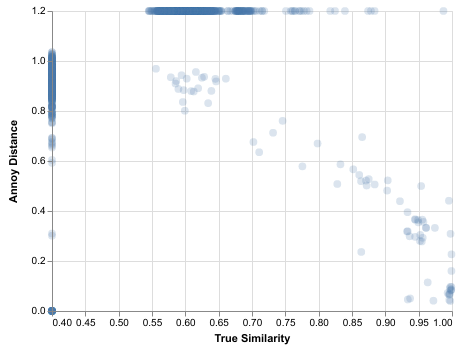

In [46]:
joint = random_neighbor_search_comparison("uva.x001319419")
alt.Chart(joint).mark_circle(size=60, opacity=0.2).encode(x=alt.X("sim", title="True Similarity", 
                                              scale=alt.Scale(zero=False)), 
                                              y =alt.X("dist", title="Annoy Distance", 
                                              scale=alt.Scale(zero=False)))


Now I take twenty random books and look at the summary statistics. I'll look at precision and recall for matches greater than 0.9 in cosine similarity (which are generally from the same book) and those below 0.9 (which are not).

In [47]:
from collections import Counter, defaultdict

counts = defaultdict(Counter)
for _ in range(50):
    j = random_neighbor_search_comparison()

    for row in j.itertuples():
        if row.sim > .9:
            d = "> .9"
        else:
            d = "<= .9"
        matched = not pd.isna(row.rank)
        counts[d][matched] += 1
    print(counts)

1590 and 1590 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 1590, False: 1363})})


/home/bschmidt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bschmidt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2040 and 2040 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 3624, False: 3384}), '> .9': Counter({True: 6, False: 1})})


600 and 600 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 4207, False: 3926}), '> .9': Counter({True: 23, False: 2})})


600 and 600 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 4708, False: 4295}), '> .9': Counter({True: 122, False: 9})})


2040 and 2040 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 6430, False: 5435}), '> .9': Counter({True: 440, False: 22})})


2010 and 2010 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 8225, False: 6707}), '> .9': Counter({True: 655, False: 31})})


870 and 870 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 9024, False: 7484}), '> .9': Counter({True: 726, False: 34})})


18600 and 18600 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 27624, False: 25640}), '> .9': Counter({True: 726, False: 34})})


90 and 90 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 27712, False: 25727}), '> .9': Counter({True: 728, False: 35})})


360 and 360 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 28052, False: 26018}), '> .9': Counter({True: 748, False: 39})})


540 and 540 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 28592, False: 26553}), '> .9': Counter({True: 748, False: 39})})


840 and 840 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 29340, False: 27264}), '> .9': Counter({True: 840, False: 44})})


870 and 870 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 30154, False: 28076}), '> .9': Counter({True: 896, False: 46})})


1560 and 1560 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 31689, False: 29594}), '> .9': Counter({True: 921, False: 50})})


270 and 270 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 31910, False: 29794}), '> .9': Counter({True: 970, False: 56})})


420 and 420 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 32288, False: 30090}), '> .9': Counter({True: 1012, False: 60})})


90 and 90 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 32376, False: 30177}), '> .9': Counter({True: 1014, False: 61})})


720 and 720 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 32934, False: 30332}), '> .9': Counter({True: 1176, False: 75})})


60 and 60 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 32994, False: 30392}), '> .9': Counter({True: 1176, False: 75})})


3660 and 3660 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 36456, False: 32924}), '> .9': Counter({True: 1374, False: 84})})


30 and 30 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 36486, False: 32954}), '> .9': Counter({True: 1374, False: 84})})


30 and 30 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 36516, False: 32984}), '> .9': Counter({True: 1374, False: 84})})


300 and 300 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 36807, False: 33261}), '> .9': Counter({True: 1383, False: 85})})


780 and 780 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 37587, False: 34039}), '> .9': Counter({True: 1383, False: 85})})


1020 and 1020 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 38538, False: 34890}), '> .9': Counter({True: 1452, False: 88})})


360 and 360 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 38854, False: 35174}), '> .9': Counter({True: 1496, False: 92})})


90 and 90 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 38940, False: 35258}), '> .9': Counter({True: 1500, False: 94})})


600 and 600 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 39422, False: 35728}), '> .9': Counter({True: 1618, False: 101})})


300 and 300 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 39722, False: 36025}), '> .9': Counter({True: 1618, False: 101})})


240 and 240 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 39961, False: 36254}), '> .9': Counter({True: 1619, False: 102})})


300 and 300 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 40252, False: 36539}), '> .9': Counter({True: 1628, False: 103})})


330 and 330 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 40524, False: 36795}), '> .9': Counter({True: 1686, False: 114})})


660 and 660 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 41184, False: 37415}), '> .9': Counter({True: 1686, False: 114})})


60 and 60 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 41244, False: 37474}), '> .9': Counter({True: 1686, False: 114})})


270 and 270 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 41511, False: 37728}), '> .9': Counter({True: 1689, False: 115})})


990 and 990 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 42452, False: 38561}), '> .9': Counter({True: 1738, False: 118})})


900 and 900 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 43290, False: 39298}), '> .9': Counter({True: 1800, False: 148})})


960 and 960 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 44221, False: 40212}), '> .9': Counter({True: 1829, False: 151})})


1260 and 1260 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 45440, False: 41223}), '> .9': Counter({True: 1870, False: 154})})


240 and 240 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 45678, False: 41454}), '> .9': Counter({True: 1872, False: 155})})


780 and 780 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 46448, False: 42196}), '> .9': Counter({True: 1882, False: 159})})


390 and 390 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 46838, False: 42586}), '> .9': Counter({True: 1882, False: 159})})


1020 and 1020 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 47794, False: 43533}), '> .9': Counter({True: 1946, False: 161})})


210 and 210 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 47988, False: 43717}), '> .9': Counter({True: 1962, False: 165})})


60 and 60 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 48048, False: 43776}), '> .9': Counter({True: 1962, False: 165})})


1290 and 1290 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 49254, False: 44868}), '> .9': Counter({True: 2046, False: 173})})


1740 and 1740 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 50919, False: 46371}), '> .9': Counter({True: 2121, False: 180})})


30 and 30 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 50949, False: 46400}), '> .9': Counter({True: 2121, False: 181})})


810 and 810 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 51684, False: 46923}), '> .9': Counter({True: 2196, False: 184})})


390 and 390 items returned
defaultdict(<class 'collections.Counter'>, {'<= .9': Counter({True: 52074, False: 47313}), '> .9': Counter({True: 2196, False: 184})})


## Summary statistics

Print summary statistics for the two breakpoints that I'm using.

In [51]:
for key in ['> .9', '<= .9']:
    t = counts[key][True]
    f = counts[key][False]
    print("For true similarity of {}, recall by Annoy is {:.03%}".format(key, t/(t+f)))

For true similarity of > .9, recall by Annoy is 92.269%
For true similarity of <= .9, recall by Annoy is 52.395%


To get matches with distances and ranks in a DataFrame, use `get_named_result_df`. This is useful in higher leel methods.

In [31]:
# The self-match is dropped, so n=5 returns 4 results. Changing
# that in code seemed more confusing, since the n elsewhere includes
# the self-match
ann.get_named_result_df(mtid='mdp.39015002704628-0030', n=25)

,target,target_seq,match,match_seq,dist,rank
0,mdp.39015002704941,9,mdp.39015002704941,9,0.000083,0
1,mdp.39015002704941,9,mdp.39015060617787,10,0.723806,1
2,mdp.39015002704941,9,pst.000033671451,8,0.726845,2
3,mdp.39015002704941,9,mdp.39015049863924,14,0.731165,3
4,mdp.39015002704941,9,uc1.$b322952,9,0.739236,4
5,mdp.39015002704941,9,mdp.39015014771615,4,0.739399,5
6,mdp.39015002704941,9,mdp.39015050115784,26,0.743193,6
7,mdp.39015002704941,9,mdp.39015009053367,17,0.744713,7
8,mdp.39015002704941,9,mdp.39015017926224,19,0.748099,8
9,mdp.39015002704941,9,mdp.39015009131031,26,0.748813,9


Metadata is in `ann.ind`